# Clustering des étudiants


## Importation des données


In [11]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
import numpy as np
import sys
import os
import pandas as pd
import ast
from dotenv import load_dotenv
import seaborn as sns
load_dotenv()
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from api.services.database_helper import get_all_vectors_from_db, connect_to_db

In [12]:
from pymongo import MongoClient
import pandas as pd

# Connexion à MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["G1"]

# Récupération des messages (si tu as une collection séparée)
messages = list(db.documents.find({}))  # Collection des messages individuels

df_messages = pd.DataFrame(messages)
df_messages.head()

,_id,endorsed,created_at,read,closed,context,updated_at,username,at_position_list,courseware_title,...,parent_id,resp_limit,last_activity_at,endorsed_responses,non_endorsed_resp_total,non_endorsed_responses,endorsement,is_commentable_divided,group_name,group_id
0,52ef4b71ab137b00720007d4,False,2014-02-03T07:55:29Z,True,False,course,2014-02-03T07:55:29Z,qb,[],Entre nous / Presentez-vous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52ef5f60919cec5e32000962,False,2014-02-03T09:20:32Z,NaN,False,NaN,2014-02-03T09:20:32Z,MountacirAmar,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52ef4d79b4907d2e23000996,False,2014-02-03T08:04:09Z,True,False,course,2014-02-03T08:04:09Z,fidji,[],Entre nous / Presentez-vous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52ef73945c4baf9e610008a8,False,2014-02-03T10:46:44Z,NaN,False,NaN,2014-02-03T10:46:44Z,ElenaThomas,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52efa3b5cfc81d7e410009a3,False,2014-02-03T14:12:05Z,NaN,False,NaN,2014-02-03T14:12:05Z,BEJA,[],NaN,...,52ef73945c4baf9e610008a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
threads = list(db.threads.find({}))
df_threads = pd.DataFrame(threads)
print("Colonnes du DataFrame :", df_threads.columns)

if 'content' in df_threads.columns:
    df_content = pd.json_normalize(df_threads['content'])
    df_content['_id'] = df_threads['_id']
    print("Champs extraits de 'content' :", df_content.columns)
else:
    # Essayons de tout aplatir
    df_content = pd.json_normalize(threads)
    print("Champs extraits (aplatissage global) :", df_content.columns)
    # Cherche les colonnes qui commencent par 'content.'
    print([col for col in df_content.columns if col.startswith('content.')])

Colonnes du DataFrame : Index(['_id', 'content', 'annotated_content_info', '_users'], dtype='object')
Champs extraits de 'content' : Index(['endorsed', 'created_at', 'read', 'closed', 'context', 'updated_at',
       'username', 'at_position_list', 'courseware_title', 'pinned',
       'children', 'user_id', 'thread_type', 'abuse_flaggers', 'resp_total',
       'anonymous', 'courseware_url', 'type', 'resp_skip', 'course_id',
       'commentable_id', 'unread_comments_count', 'title', 'body', 'id',
       'comments_count', 'anonymous_to_peers', 'votes.down_count',
       'votes.point', 'votes.up_count', 'votes.count', 'resp_limit',
       'endorsed_responses', 'non_endorsed_resp_total',
       'non_endorsed_responses', 'last_activity_at', 'is_commentable_divided',
       'group_name', 'group_id', '_id'],
      dtype='object')


In [14]:
df_threads.head()

,_id,content,annotated_content_info,_users
0,52ef4b71ab137b00720007d4,"{'endorsed': False, 'created_at': '2014-02-03T...",{'52ef5f60919cec5e32000962': {'ability': {'can...,qb (MountacirAmar )
1,52ef4d79b4907d2e23000996,"{'context': 'course', 'closed': False, 'endors...","{'52ef73945c4baf9e610008a8': {'voted': '', 'su...",fidji (ElenaThomas (BEJA )ElenaThomas )
2,52ef4f99344caaf903000158,"{'user_id': '149732', 'thread_type': 'discussi...","{'52efba725c4baf9e61000928': {'voted': '', 'ab...",ambruleaux (danielgv )
3,52ef50b5cfc81d7e4100090e,"{'user_id': '301008', 'thread_type': 'discussi...",{'52ef50b5cfc81d7e4100090e': {'ability': {'can...,EricBouchet (Virginiebio )
4,52ef565b4b4451380f0008b2,"{'closed': False, 'context': 'course', 'endors...","{'52ef9449cfc81d7e4100098c': {'voted': '', 'ab...",edwigedk (EricBouchet LaurenceDidierjean lming...


In [15]:
df_messages.head()

,_id,endorsed,created_at,read,closed,context,updated_at,username,at_position_list,courseware_title,...,parent_id,resp_limit,last_activity_at,endorsed_responses,non_endorsed_resp_total,non_endorsed_responses,endorsement,is_commentable_divided,group_name,group_id
0,52ef4b71ab137b00720007d4,False,2014-02-03T07:55:29Z,True,False,course,2014-02-03T07:55:29Z,qb,[],Entre nous / Presentez-vous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,52ef5f60919cec5e32000962,False,2014-02-03T09:20:32Z,NaN,False,NaN,2014-02-03T09:20:32Z,MountacirAmar,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,52ef4d79b4907d2e23000996,False,2014-02-03T08:04:09Z,True,False,course,2014-02-03T08:04:09Z,fidji,[],Entre nous / Presentez-vous,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,52ef73945c4baf9e610008a8,False,2014-02-03T10:46:44Z,NaN,False,NaN,2014-02-03T10:46:44Z,ElenaThomas,[],NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,52efa3b5cfc81d7e410009a3,False,2014-02-03T14:12:05Z,NaN,False,NaN,2014-02-03T14:12:05Z,BEJA,[],NaN,...,52ef73945c4baf9e610008a8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# On regroupe les informations par utilisateur
user_profiles = df_content.groupby('user_id').agg({
    'course_id': lambda x: list(set(x)),  # Liste unique des cours
    'body': lambda x: ' '.join(x),        # Tous les messages concaténés
    'title': lambda x: ' || '.join(x),    # Tous les titres concaténés
    'votes.count': 'sum',                 # Total des votes
    'comments_count': 'sum',              # Total des commentaires
    'created_at': 'min',                  # Date du premier post
    'updated_at': 'max'                   # Date du dernier post
}).reset_index()

In [17]:
df_content["user_id"]

0          281811
1          268092
2          149732
3          301008
4           79036
           ...   
73641         NaN
73642    19499896
73643    20769732
73644    19499896
73645    20730476
Name: user_id, Length: 73646, dtype: object

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
import numpy as np

# Texte
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(user_profiles['body'])

# Cours
mlb = MultiLabelBinarizer()
X_courses = mlb.fit_transform(user_profiles['course_id'])

# Variables numériques
X_num = user_profiles[['votes.count', 'comments_count']].fillna(0).values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Concaténation
from scipy.sparse import hstack
X = hstack([X_text, X_courses, X_num_scaled])
X = X.tocsr()  # Conversion en CSR pour permettre l'indexation

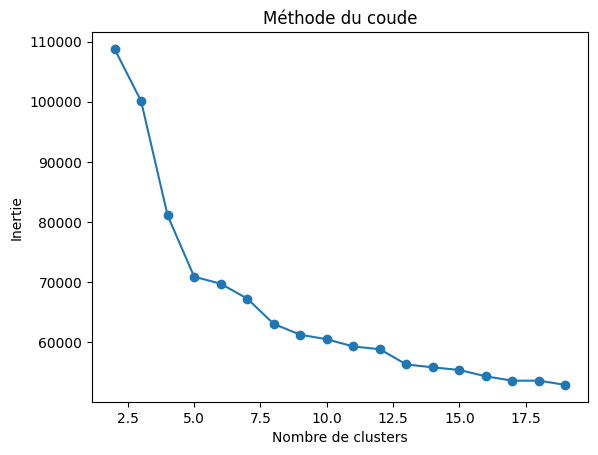

In [19]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# X = ta matrice de features (voir messages précédents)

# Trouver le nombre optimal de clusters (méthode du coude)
inertia = []
K = range(2, 20)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

In [20]:
# Choisis le K où la courbe "plie" (le coude)
k_optimal = 5  # Par exemple

# Clustering final
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X)

# Ajoute les labels à ton DataFrame utilisateur
user_profiles['cluster'] = labels

In [21]:
user_profiles["cluster"].value_counts()

cluster
4    24128
0    12022
2       84
3        2
1        1
Name: count, dtype: int64

In [22]:
# Afficher tous les utilisateurs du cluster 1
utilisateurs_cluster_1 = user_profiles[user_profiles['cluster'] == 8].head(50)

print(utilisateurs_cluster_1[['user_id', 'course_id', 'votes.count', 'comments_count']])

Empty DataFrame
Columns: [user_id, course_id, votes.count, comments_count]
Index: []


In [23]:
# Afficher tous les utilisateurs du cluster 3
utilisateurs_cluster_1 = user_profiles[user_profiles['cluster'] == 3]

print(utilisateurs_cluster_1[['user_id', 'course_id', 'votes.count', 'comments_count']])

       user_id                                          course_id  \
9748   1715116  [course-v1:USPC+37007+session01, course-v1:Par...   
17488  3431977  [course-v1:ensam+022004+session01, OBSPM/62002...   

       votes.count  comments_count  
9748           491             890  
17488          697             903  


In [24]:
# Afficher tous les utilisateurs du cluster 4
utilisateurs_cluster_1 = user_profiles[user_profiles['cluster'] == 4]

print(utilisateurs_cluster_1[['user_id', 'course_id', 'votes.count', 'comments_count']])

        user_id                                   course_id  votes.count  \
3       1000197            [course-v1:uved+34003+session02]            0   
4      10002601  [course-v1:univ-toulouse+101016+session01]            0   
5       1000263            [course-v1:CNAM+01002+session05]            0   
6        100033       [MinesTelecom/04002/Trimestre_1_2014]            0   
7      10004516            [course-v1:CNAM+01024+session03]            0   
...         ...                                         ...          ...   
36229    999456           [MinesTelecom/04014S03/session03]            0   
36230     99946            [course-v1:CNAM+01028+session01]            0   
36232    999666        [isaesupaero/25001/Trimestre_4_2014]            0   
36234    999768        [isaesupaero/25001/Trimestre_4_2014]            0   
36235   9999476    [course-v1:MinesTelecom+04026+session03]            0   

       comments_count  
3                   1  
4                   1  
5              

In [25]:
# Filtrer les utilisateurs du cluster 1
utilisateurs_cluster_1 = user_profiles[user_profiles['cluster'] == 1]

# Exploser la colonne 'course_id' pour avoir une ligne par utilisateur et par cours
cours_exploses = utilisateurs_cluster_1.explode('course_id')

# Compter le nombre d'utilisateurs par cours
compte_cours = cours_exploses['course_id'].value_counts()

print("Nombre d'utilisateurs par cours dans le cluster 1 :")
print(compte_cours)

Nombre d'utilisateurs par cours dans le cluster 1 :


course_id
course-v1:MITx+Launch.x_2+2T2016    1
Name: count, dtype: int64


In [26]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# 1. Sélectionner un utilisateur au hasard
user_idx = np.random.choice(user_profiles.index)
user_id = user_profiles.loc[user_idx, 'user_id']
user_cluster = user_profiles.loc[user_idx, 'cluster']

print(f"Utilisateur sélectionné : {user_id} (cluster {user_cluster})")

# 2. Récupérer les indices des utilisateurs du même cluster (hors lui-même)
same_cluster_idx = user_profiles[(user_profiles['cluster'] == user_cluster) & (user_profiles['user_id'] != user_id)].index

if len(same_cluster_idx) == 0:
    print("Aucun autre utilisateur dans ce cluster.")
else:
    # 3. Calculer la similarité cosinus entre l'utilisateur et les autres du cluster
    user_vector = X[user_idx]
    cluster_vectors = X[same_cluster_idx]
    similarities = cosine_similarity(user_vector, cluster_vectors).flatten()

    # 4. Trouver les 10 plus proches
    top_indices = similarities.argsort()[::-1][:10]
    closest_idx = same_cluster_idx[top_indices]

    print("Les 10 utilisateurs les plus proches dans le même cluster :")
    print(user_profiles.loc[closest_idx, ['user_id', 'course_id', 'votes.count', 'comments_count']])

Utilisateur sélectionné : 5728042 (cluster 4)
Les 10 utilisateurs les plus proches dans le même cluster :
        user_id                                 course_id  votes.count  \
28687   6212887         [course-v1:UPSUD+42001+session08]            0   
310    10203866  [course-v1:MinesTelecom+04026+session03]            0   
2442   10949695  [course-v1:MinesTelecom+04026+session03]            0   
16482   3107816         [course-v1:UPSUD+42001+session08]            0   
27593   5938528         [course-v1:UPSUD+42001+session08]            0   
4876    1175637  [course-v1:MinesTelecom+04026+session03]            0   
26049   5595761         [course-v1:UPSUD+42001+session08]            0   
23184   4959355         [course-v1:UPSUD+42001+session08]            0   
27819   5995105         [course-v1:UPSUD+42001+session08]            0   
35191   9300986  [course-v1:MinesTelecom+04026+session03]            0   

       comments_count  
28687               6  
310                 1  
2442   

## Clustering with embeddings (postgresql)

In [27]:
import psycopg2
import pandas as pd

# Connexion à la base PostgreSQL
conn = psycopg2.connect(
    dbname="postgres",
    user="postgres",         # Remplace par ton utilisateur
    password="testitesta", # Remplace par ton mot de passe
    host="localhost",
    port=5432
)

# Requête SQL pour joindre les tables
query = """
SELECT 
    embedding.id AS embedding_id,
    embedding.vector,
    embedding.thread_id,
    t1.course_id,
    c.name AS course_name
FROM embedding
LEFT JOIN threads t1 ON t1.id = embedding.id
LEFT JOIN threads t2 ON t2.id = embedding.thread_id
LEFT JOIN courses c ON c.id = COALESCE(t1.course_id, t2.course_id)
"""

# Lecture dans un DataFrame pandas
df = pd.read_sql(query, conn)
conn.close()

C:\Users\melos\AppData\Local\Temp\ipykernel_24596\466487132.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [28]:
df

,embedding_id,vector,thread_id,course_id,course_name
0,591321e91c89dc637f008359,"[-0.08292387,0.14499894,0.04023657,0.082722746...",591242041c89dc637f0082a4,NaN,course-v1:ensam+022005+session01
1,591243f2a0241e069e0083c5,"[0.0035491593,0.20026675,0.04343643,0.05415875...",,123.0,course-v1:ensam+022005+session01
2,5912466da0241e839c00832e,"[0.1760185,0.078938894,0.0009793746,-0.1306310...",,122.0,course-v1:UPVD+95003+session01
3,591247b21c89dc637f0082a7,"[-0.019320067,-0.21708304,0.20142823,-0.123409...",,207.0,course-v1:univartois+35001+session03
4,5914a69da0241e839c00853b,"[-0.16032948,0.09425501,0.1590983,0.006597066,...",591243f2a0241e069e0083c5,NaN,course-v1:ensam+022005+session01
...,...,...,...,...,...
178503,591785e1a0241eab2c00872f,"[0.101391874,-0.13729566,-0.008471651,-0.02492...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01
178504,5917885ba0241eab2c008730,"[0.040281072,-0.18650845,0.0512674,0.015381444...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01
178505,591242041c89dc637f0082a4,"[-0.030751333,0.1747488,0.041722033,0.06200558...",,123.0,course-v1:ensam+022005+session01
178506,591242d91c89dc530200855e,"[-0.059681233,0.26217616,0.1171786,0.17608218,...",,123.0,course-v1:ensam+022005+session01


In [29]:
import numpy as np

def parse_vector(v):
    # Si déjà un tuple/list de floats
    if isinstance(v, (list, tuple)) and isinstance(v[0], (float, np.floating, int)):
        return np.array(v)
    # Si c'est une chaîne de type "[...]" ou "(...)"
    if isinstance(v, str):
        v = v.strip("[]()")
        return np.array([float(x) for x in v.split(",")])
    raise ValueError(f"Format inattendu pour le vecteur : {v}")

# Appliquer à toutes les lignes valides
mask_valid = df['vector'].notnull()
df_valid = df[mask_valid].copy()
df_valid['vector_np'] = df_valid['vector'].apply(parse_vector)
X_emb = np.stack(df_valid['vector_np'].values)

In [30]:
from sklearn.cluster import KMeans

k = 4  # Par exemple
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
labels = kmeans.fit_predict(X_emb)
df['cluster'] = labels

In [31]:
labels

array([1, 1, 3, ..., 1, 1, 1])

In [32]:
df["cluster"].value_counts()

cluster
1    69800
0    38246
3    36876
2    33586
Name: count, dtype: int64

### Test 3 clustering

In [33]:
import numpy as np

def parse_vector(v):
    if isinstance(v, (list, tuple)) and isinstance(v[0], (float, np.floating, int)):
        return np.array(v)
    if isinstance(v, str):
        v = v.strip("[]()")
        return np.array([float(x) for x in v.split(",")])
    raise ValueError(f"Format inattendu pour le vecteur : {v}")

df['vector_np'] = df['vector'].apply(parse_vector)

In [34]:
df

,embedding_id,vector,thread_id,course_id,course_name,cluster,vector_np
0,591321e91c89dc637f008359,"[-0.08292387,0.14499894,0.04023657,0.082722746...",591242041c89dc637f0082a4,NaN,course-v1:ensam+022005+session01,1,"[-0.08292387, 0.14499894, 0.04023657, 0.082722..."
1,591243f2a0241e069e0083c5,"[0.0035491593,0.20026675,0.04343643,0.05415875...",,123.0,course-v1:ensam+022005+session01,1,"[0.0035491593, 0.20026675, 0.04343643, 0.05415..."
2,5912466da0241e839c00832e,"[0.1760185,0.078938894,0.0009793746,-0.1306310...",,122.0,course-v1:UPVD+95003+session01,3,"[0.1760185, 0.078938894, 0.0009793746, -0.1306..."
3,591247b21c89dc637f0082a7,"[-0.019320067,-0.21708304,0.20142823,-0.123409...",,207.0,course-v1:univartois+35001+session03,1,"[-0.019320067, -0.21708304, 0.20142823, -0.123..."
4,5914a69da0241e839c00853b,"[-0.16032948,0.09425501,0.1590983,0.006597066,...",591243f2a0241e069e0083c5,NaN,course-v1:ensam+022005+session01,1,"[-0.16032948, 0.09425501, 0.1590983, 0.0065970..."
...,...,...,...,...,...,...,...
178503,591785e1a0241eab2c00872f,"[0.101391874,-0.13729566,-0.008471651,-0.02492...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01,0,"[0.101391874, -0.13729566, -0.008471651, -0.02..."
178504,5917885ba0241eab2c008730,"[0.040281072,-0.18650845,0.0512674,0.015381444...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01,1,"[0.040281072, -0.18650845, 0.0512674, 0.015381..."
178505,591242041c89dc637f0082a4,"[-0.030751333,0.1747488,0.041722033,0.06200558...",,123.0,course-v1:ensam+022005+session01,1,"[-0.030751333, 0.1747488, 0.041722033, 0.06200..."
178506,591242d91c89dc530200855e,"[-0.059681233,0.26217616,0.1171786,0.17608218,...",,123.0,course-v1:ensam+022005+session01,1,"[-0.059681233, 0.26217616, 0.1171786, 0.176082..."


In [35]:
df

,embedding_id,vector,thread_id,course_id,course_name,cluster,vector_np
0,591321e91c89dc637f008359,"[-0.08292387,0.14499894,0.04023657,0.082722746...",591242041c89dc637f0082a4,NaN,course-v1:ensam+022005+session01,1,"[-0.08292387, 0.14499894, 0.04023657, 0.082722..."
1,591243f2a0241e069e0083c5,"[0.0035491593,0.20026675,0.04343643,0.05415875...",,123.0,course-v1:ensam+022005+session01,1,"[0.0035491593, 0.20026675, 0.04343643, 0.05415..."
2,5912466da0241e839c00832e,"[0.1760185,0.078938894,0.0009793746,-0.1306310...",,122.0,course-v1:UPVD+95003+session01,3,"[0.1760185, 0.078938894, 0.0009793746, -0.1306..."
3,591247b21c89dc637f0082a7,"[-0.019320067,-0.21708304,0.20142823,-0.123409...",,207.0,course-v1:univartois+35001+session03,1,"[-0.019320067, -0.21708304, 0.20142823, -0.123..."
4,5914a69da0241e839c00853b,"[-0.16032948,0.09425501,0.1590983,0.006597066,...",591243f2a0241e069e0083c5,NaN,course-v1:ensam+022005+session01,1,"[-0.16032948, 0.09425501, 0.1590983, 0.0065970..."
...,...,...,...,...,...,...,...
178503,591785e1a0241eab2c00872f,"[0.101391874,-0.13729566,-0.008471651,-0.02492...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01,0,"[0.101391874, -0.13729566, -0.008471651, -0.02..."
178504,5917885ba0241eab2c008730,"[0.040281072,-0.18650845,0.0512674,0.015381444...",59123e47a0241e069e0083c0,NaN,course-v1:isentoulon+112001+session01,1,"[0.040281072, -0.18650845, 0.0512674, 0.015381..."
178505,591242041c89dc637f0082a4,"[-0.030751333,0.1747488,0.041722033,0.06200558...",,123.0,course-v1:ensam+022005+session01,1,"[-0.030751333, 0.1747488, 0.041722033, 0.06200..."
178506,591242d91c89dc530200855e,"[-0.059681233,0.26217616,0.1171786,0.17608218,...",,123.0,course-v1:ensam+022005+session01,1,"[-0.059681233, 0.26217616, 0.1171786, 0.176082..."


In [43]:
# Cellule 2 (optimisée): Création d'un dataframe complet par utilisateur
def créer_profils_utilisateurs_optimisé():
    # 1. Extraire et préparer les données de MongoDB
    print("Étape 1: Agrégation des données utilisateur...")
    user_data = df_content.groupby('user_id').agg({
        'course_id': lambda x: list(set(x)),
        'votes.count': 'sum',
        'comments_count': 'sum',
        'created_at': 'min',
        'updated_at': 'max',
        '_id': 'count'
    }).reset_index()
    
    user_data.rename(columns={'_id': 'nb_messages'}, inplace=True)
    user_data['engagement_score'] = user_data['votes.count'] + user_data['comments_count'] * 2 + user_data['nb_messages'] * 3
    
    # 3. Extraction des vecteurs d'embedding - OPTIMISÉ
    print("Étape 2: Préparation du mapping thread -> utilisateur...")
    # Créer un mapping thread_id -> user_id une seule fois
    thread_to_user = df_content[['_id', 'user_id']].rename(columns={'_id': 'embedding_id'}).dropna()
    thread_user_mapping = dict(zip(thread_to_user['embedding_id'], thread_to_user['user_id']))
    
    print("Étape 3: Agrégation des embeddings par utilisateur...")
    # Ajouter l'utilisateur à chaque ligne du dataframe d'embeddings
    df_with_users = df.copy()
    df_with_users['user_id'] = df_with_users['embedding_id'].map(thread_user_mapping)
    
    # Filtrer les lignes où l'utilisateur est identifié
    df_with_users = df_with_users.dropna(subset=['user_id', 'vector_np'])
    
    # Utiliser groupby pour calculer la moyenne des vecteurs par utilisateur
    user_embeddings = {}
    
    # Limiter le nombre d'utilisateurs pour le test (enlever pour production)
    # max_users = 1000  # Commentez cette ligne pour traiter tous les utilisateurs
    
    # Pour chaque 1000 utilisateurs, traiter par lots pour éviter les problèmes de mémoire
    unique_users = df_with_users['user_id'].unique()
    # unique_users = unique_users[:max_users]  # Commentez cette ligne pour traiter tous les utilisateurs
    
    print(f"Traitement des embeddings pour {len(unique_users)} utilisateurs...")
    
    batch_size = 1000
    for i in range(0, len(unique_users), batch_size):
        batch_users = unique_users[i:i+batch_size]
        print(f"Traitement du lot {i//batch_size + 1}/{(len(unique_users)-1)//batch_size + 1}...")
        
        batch_df = df_with_users[df_with_users['user_id'].isin(batch_users)]
        
        for user_id, group in batch_df.groupby('user_id'):
            vectors = list(group['vector_np'])
            if vectors:
                avg_embedding = np.mean(vectors, axis=0)
                user_embeddings[user_id] = avg_embedding
    
    print("Traitement terminé!")
    return user_data, user_embeddings

# Exécuter la fonction
user_profiles, user_embeddings = créer_profils_utilisateurs_optimisé()
print(f"Nombre d'utilisateurs avec profil: {len(user_profiles)}")
print(f"Nombre d'utilisateurs avec embeddings: {len(user_embeddings)}")

Étape 1: Agrégation des données utilisateur...
Étape 2: Préparation du mapping thread -> utilisateur...
Étape 3: Agrégation des embeddings par utilisateur...
Traitement des embeddings pour 36237 utilisateurs...
Traitement du lot 1/37...
Traitement du lot 2/37...
Traitement du lot 3/37...
Traitement du lot 4/37...
Traitement du lot 5/37...
Traitement du lot 6/37...
Traitement du lot 7/37...
Traitement du lot 8/37...
Traitement du lot 9/37...
Traitement du lot 10/37...
Traitement du lot 11/37...
Traitement du lot 12/37...
Traitement du lot 13/37...
Traitement du lot 14/37...
Traitement du lot 15/37...
Traitement du lot 16/37...
Traitement du lot 17/37...
Traitement du lot 18/37...
Traitement du lot 19/37...
Traitement du lot 20/37...
Traitement du lot 21/37...
Traitement du lot 22/37...
Traitement du lot 23/37...
Traitement du lot 24/37...
Traitement du lot 25/37...
Traitement du lot 26/37...
Traitement du lot 27/37...
Traitement du lot 28/37...
Traitement du lot 29/37...
Traitement du l

In [44]:
# Cellule 3: Préparation des données pour le clustering
from sklearn.preprocessing import StandardScaler

def préparer_données_clustering(user_profiles, user_embeddings):
    # Utilisateurs avec embeddings
    users_with_embedding = list(set(user_profiles['user_id']) & set(user_embeddings.keys()))
    print(f"Nombre d'utilisateurs avec profil et embeddings: {len(users_with_embedding)}")
    
    # Sous-ensemble des utilisateurs avec embeddings
    df_subset = user_profiles[user_profiles['user_id'].isin(users_with_embedding)].copy()
    
    # Extraction des embeddings dans l'ordre des utilisateurs du dataframe
    embedding_matrix = np.array([user_embeddings[uid] for uid in df_subset['user_id']])
    
    # Extraction des métriques d'engagement
    engagement_features = df_subset[['votes.count', 'comments_count', 'nb_messages']].fillna(0).values
    
    # Standardisation des métriques d'engagement
    scaler = StandardScaler()
    engagement_scaled = scaler.fit_transform(engagement_features)
    
    # Concaténer embeddings et métriques d'engagement
    X_combined = np.hstack([embedding_matrix, engagement_scaled * 0.5])  # 0.5 = poids des métriques
    
    return X_combined, df_subset

# Préparer les données
X_combined, df_subset = préparer_données_clustering(user_profiles, user_embeddings)

Nombre d'utilisateurs avec profil et embeddings: 36237


Recherche du k optimal sur 12 valeurs de k...
Échantillonnage de 10000 points sur 36237 pour accélérer l'analyse
Calcul parallèle sur tous les CPUs...
Calcul des inerties terminé en 40.69s
Détection automatique du coude non disponible (kneed non installé)


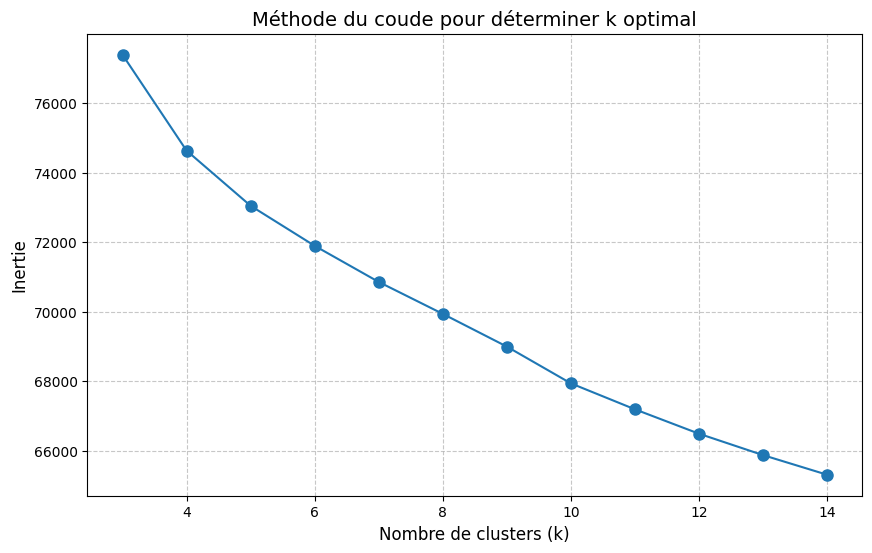

k optimal choisi: 5


In [45]:
# Cellule 4 (optimisée): Trouver le nombre optimal de clusters
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import time

def calculer_inertie(k, X_sample, random_state=42):
    """Calcule l'inertie pour un k donné sur un échantillon de données."""
    print(f"Calcul pour k={k}... ", end="", flush=True)
    start_time = time.time()
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(X_sample)
    duration = time.time() - start_time
    print(f"terminé en {duration:.2f}s")
    return kmeans.inertia_

def trouver_k_optimal_optimisé(X, k_range=range(3, 15), sample_size=10000, n_jobs=-1):
    """
    Trouve le k optimal en parallélisant les calculs et en utilisant un échantillon.
    
    Args:
        X: Données complètes
        k_range: Plage de valeurs k à tester
        sample_size: Taille de l'échantillon à utiliser (réduit pour accélérer)
        n_jobs: Nombre de jobs en parallèle (-1 = tous les CPUs)
    """
    print(f"Recherche du k optimal sur {len(k_range)} valeurs de k...")
    
    # Échantillonnage des données si nécessaire
    if X.shape[0] > sample_size:
        print(f"Échantillonnage de {sample_size} points sur {X.shape[0]} pour accélérer l'analyse")
        indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
        X_sample = X[indices]
    else:
        X_sample = X
        print(f"Utilisation de toutes les données ({X.shape[0]} points)")
        
    # Calcul parallèle des inerties
    print(f"Calcul parallèle sur {n_jobs if n_jobs > 0 else 'tous les'} CPUs...")
    start_time = time.time()
    
    inertias = Parallel(n_jobs=n_jobs)(
        delayed(calculer_inertie)(k, X_sample) for k in k_range
    )
    
    total_duration = time.time() - start_time
    print(f"Calcul des inerties terminé en {total_duration:.2f}s")
    
    # Tracer la courbe du coude
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertias, 'o-', markersize=8)
    plt.xlabel('Nombre de clusters (k)', fontsize=12)
    plt.ylabel('Inertie', fontsize=12)
    plt.title('Méthode du coude pour déterminer k optimal', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Tentative de détection automatique du coude
    try:
        # Avec kneed si installé
        kl = KneeLocator(list(k_range), inertias, curve="convex", direction="decreasing")
        k_auto = kl.elbow
        if k_auto:
            plt.axvline(x=k_auto, color='red', linestyle='--', label=f'Coude détecté: k={k_auto}')
            plt.legend()
            print(f"Coude automatiquement détecté à k={k_auto}")
    except:
        k_auto = None
        print("Détection automatique du coude non disponible (kneed non installé)")
    
    plt.show()
    
    # Choix manuel ou automatique
    if k_auto:
        user_input = input(f"Accepter k={k_auto} (détection auto) ? [o/n] ou entrez une valeur : ")
        if user_input.lower() == 'o' or user_input == '':
            return k_auto
    else:
        user_input = input("D'après le graphique, quel est le k optimal ? ")
    
    try:
        return int(user_input)
    except:
        # Si l'utilisateur a accepté la valeur auto ou a entré une valeur invalide
        return k_auto if k_auto else k_range[len(k_range)//2]  # Valeur médiane par défaut

# Trouver k optimal avec la version optimisée
k_optimal = trouver_k_optimal_optimisé(X_combined)
print(f"k optimal choisi: {k_optimal}")

In [46]:
# Cellule 5: Appliquer le clustering
def appliquer_clustering(X, df_subset, k):
    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    
    # Ajouter les labels au dataframe
    df_subset['cluster'] = labels
    
    return df_subset

# Appliquer le clustering
df_clustered = appliquer_clustering(X_combined, df_subset, k_optimal)
print(f"Distribution des clusters:\n{df_clustered['cluster'].value_counts().sort_index()}")

Distribution des clusters:
cluster
0    12764
1    11504
2        2
3     4460
4     7507
Name: count, dtype: int64


Distribution des utilisateurs par cluster:
cluster
0    12764
1    11504
2        2
3     4460
4     7507
Name: count, dtype: int64


C:\Users\melos\AppData\Local\Temp\ipykernel_24596\487802300.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df_clustered, palette='viridis')


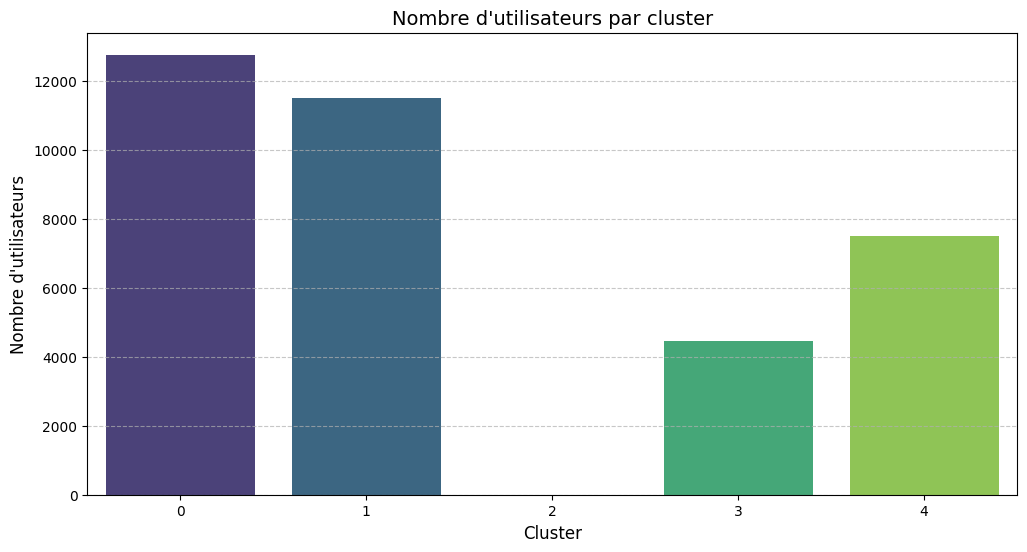


Caractéristiques moyennes par cluster:
         votes.count  comments_count  nb_messages  engagement_score  \
cluster                                                               
0           0.775854        9.985349     2.473989         28.168521   
1           0.099704        1.042072     1.174026          5.705928   
2         594.000000      896.500000   131.500000       2781.500000   
3           1.193049        1.817937     1.528251          9.413677   
4           0.629546        1.518716     2.227921         10.350739   

         nb_utilisateurs  
cluster                   
0                  12764  
1                  11504  
2                      2  
3                   4460  
4                   7507  


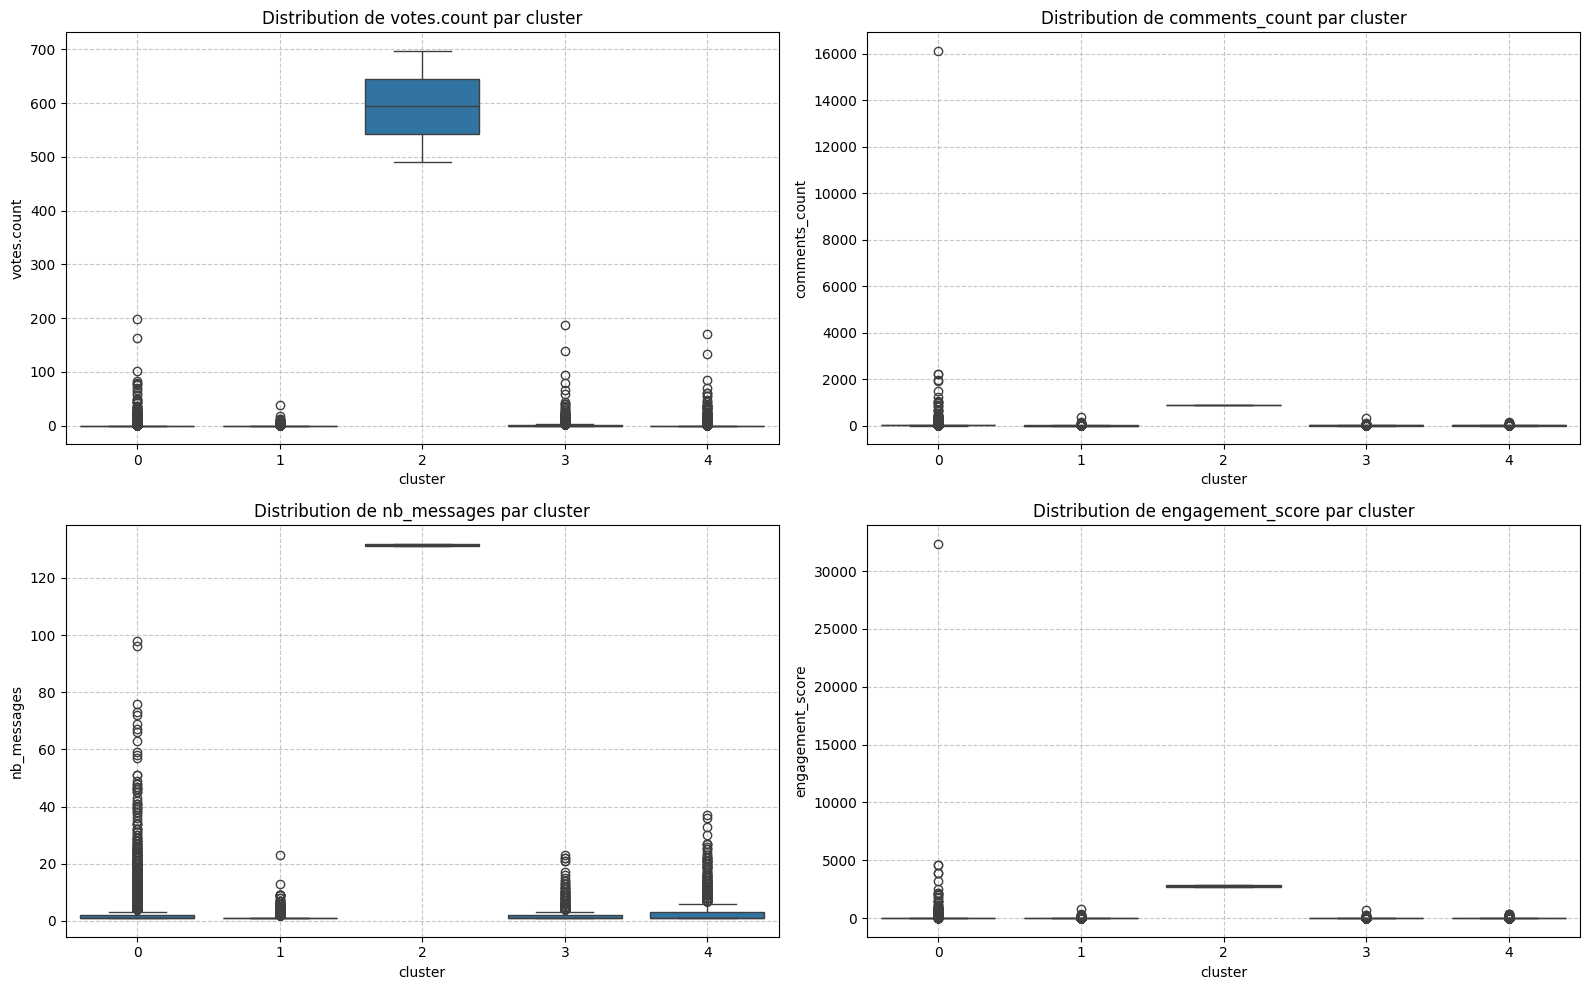


Analyse des cours par cluster:

Cluster 0 - Top 5 cours:
MinesTelecom/04017/session01              399
MinesTelecom/04019S02/session02           390
course-v1:MinesTelecom+04036+session01    380
CNAM/01002/Trimestre_1_2014               374
TUMx/AUTONAVx/2T2014                      363
Name: count, dtype: int64

Cluster 1 - Top 5 cours:
course-v1:AdelaideX+Project101x+2T2016    954
course-v1:ulb+44001+session04             590
course-v1:ColumbiaX+DS103x+2T2016         503
course-v1:IMTx+DMx102+2T2018              495
course-v1:CNAM+01032+session01            402
Name: count, dtype: int64

Cluster 2 - Top 5 cours:
course-v1:amu+38001+session02            2
OBSPM/62002/session01                    2
itii/119002/session01                    2
course-v1:USPC+37007+session01           1
course-v1:ParisSaclay+71001+session03    1
Name: count, dtype: int64

Cluster 3 - Top 5 cours:
TUMx/AUTONAVx/2T2014                      1202
course-v1:ColumbiaX+DS103x+2T2016          684
course-v1:Adelaid

In [47]:
# Cellule 6: Analyser les clusters
import seaborn as sns

def analyse_clusters(df_clustered):
    # Distribution des clusters
    print("Distribution des utilisateurs par cluster:")
    cluster_counts = df_clustered['cluster'].value_counts().sort_index()
    print(cluster_counts)
    
    # Visualisation de la distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(x='cluster', data=df_clustered, palette='viridis')
    plt.title('Nombre d\'utilisateurs par cluster', fontsize=14)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Nombre d\'utilisateurs', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    # Caractéristiques des clusters
    print("\nCaractéristiques moyennes par cluster:")
    cluster_stats = df_clustered.groupby('cluster').agg({
        'votes.count': 'mean',
        'comments_count': 'mean',
        'nb_messages': 'mean',
        'engagement_score': 'mean',
        'user_id': 'count'
    }).rename(columns={'user_id': 'nb_utilisateurs'})
    print(cluster_stats)
    
    # Visualisation des caractéristiques
    plt.figure(figsize=(16, 10))
    
    features = ['votes.count', 'comments_count', 'nb_messages', 'engagement_score']
    for i, feature in enumerate(features):
        plt.subplot(2, 2, i+1)
        sns.boxplot(x='cluster', y=feature, data=df_clustered)
        plt.title(f'Distribution de {feature} par cluster')
        plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    # Distribution des courses par cluster
    print("\nAnalyse des cours par cluster:")
    # Créer un DataFrame pour l'analyse des cours
    courses_by_cluster = []
    
    for cluster_id in sorted(df_clustered['cluster'].unique()):
        # Obtenir tous les cours pour ce cluster
        cluster_courses = []
        for courses_list in df_clustered[df_clustered['cluster'] == cluster_id]['course_id']:
            if isinstance(courses_list, list):
                cluster_courses.extend(courses_list)
        
        # Compter les occurrences
        course_counts = pd.Series(cluster_courses).value_counts().head(5)
        
        print(f"\nCluster {cluster_id} - Top 5 cours:")
        print(course_counts)

# Analyser les clusters
analyse_clusters(df_clustered)

In [41]:
df_clustered[df_clustered["cluster"]== 0]

,user_id,course_id,votes.count,comments_count,created_at,updated_at,nb_messages,engagement_score,cluster
1,10001053,[course-v1:AdelaideX+Project101x+2T2016],0,1,2016-07-07T03:44:01Z,2016-07-12T15:50:30Z,2,8,0
16,10008556,[course-v1:AdelaideX+Project101x+2T2016],0,8,2017-01-05T21:49:30Z,2017-01-30T18:21:52Z,6,34,0
26,100150,[CNAM/01002/Trimestre_1_2014],10,4,2014-02-06T18:54:22Z,2014-02-10T18:58:39Z,3,27,0
29,10016286,[course-v1:AdelaideX+Project101x+2T2016],0,2,2016-08-30T16:29:04Z,2016-09-07T13:43:41Z,6,22,0
50,10028874,[course-v1:ColumbiaX+DS103x+2T2016],0,1,2016-05-16T03:29:53Z,2016-07-31T15:44:38Z,7,23,0
...,...,...,...,...,...,...,...,...,...
36192,9970306,[course-v1:AdelaideX+Project101x+2T2016],0,2,2016-06-20T21:06:01Z,2016-07-08T06:46:28Z,3,13,0
36199,9975649,[course-v1:AdelaideX+Project101x+2T2016],0,2,2016-06-17T20:07:43Z,2016-07-09T14:14:10Z,4,16,0
36214,998631,[course-v1:CNAM+01030+session01],0,1,2018-03-20T17:49:04Z,2018-03-20T17:49:04Z,1,5,0
36215,9986721,[course-v1:lyon3+26001+session05],0,1,2019-01-09T10:01:10Z,2019-02-19T15:18:22Z,2,8,0


In [48]:
# Cellule 7: Fonction pour trouver des utilisateurs similaires
from sklearn.metrics.pairwise import cosine_similarity

def trouver_utilisateurs_similaires(user_id, df_clustered, X, top_n=5):
    if user_id not in df_clustered['user_id'].values:
        print(f"L'utilisateur {user_id} n'est pas dans le dataset.")
        return None
    
    # Trouver l'index et le cluster de l'utilisateur
    user_idx = df_clustered[df_clustered['user_id'] == user_id].index[0]
    user_cluster = df_clustered.loc[user_idx, 'cluster']
    
    # Trouver les utilisateurs du même cluster
    same_cluster_indices = df_clustered[df_clustered['cluster'] == user_cluster].index
    
    # Calculer les similarités
    user_vector = X[user_idx].reshape(1, -1)
    print(user_vector)
    print(X[same_cluster_indices])
    similarities = cosine_similarity(user_vector, X[same_cluster_indices]).flatten()
    
    # Créer un dataframe avec les similarités
    sim_df = pd.DataFrame({
        'user_id': df_clustered.loc[same_cluster_indices, 'user_id'].values,
        'similarity': similarities
    })
    
    # Exclure l'utilisateur lui-même
    sim_df = sim_df[sim_df['user_id'] != user_id]
    
    # Trier par similarité décroissante
    top_similar = sim_df.sort_values('similarity', ascending=False).head(top_n)
    
    return top_similar

# Exemple avec un utilisateur aléatoire
import random
exemple_user_id = random.choice(df_clustered['user_id'].tolist())
print(f"Informations sur l'utilisateur exemple (ID: {exemple_user_id}):")
print(df_clustered[df_clustered['user_id'] == exemple_user_id][['votes.count', 'comments_count', 'nb_messages', 'cluster', 'course_id']])

# Trouver des utilisateurs similaires
similar_users = trouver_utilisateurs_similaires(exemple_user_id, df_clustered, X_combined, top_n=5)
print(f"\nUtilisateurs similaires à {exemple_user_id}:")
print(similar_users)

# Afficher les détails des utilisateurs similaires
similar_details = df_clustered[df_clustered['user_id'].isin(similar_users['user_id'])]
print("\nDétails des utilisateurs similaires:")
print(similar_details[['user_id', 'votes.count', 'comments_count', 'nb_messages', 'cluster', "course_id"]])

Informations sur l'utilisateur exemple (ID: 3800547):
       votes.count  comments_count  nb_messages  cluster  \
18615            0              11            1        0   

                             course_id  
18615  [course-v1:amu+38008+session01]  
[[-5.69212920e-02  2.46769030e-01  1.75821660e-01 -1.55188255e-02
   2.90631860e-01 -1.41904160e-01  1.99765680e-01  1.01195660e-01
   1.50675970e-01 -6.48160000e-03 -1.01596680e-02 -4.38303600e-02
  -1.39169980e-01 -4.30686800e-03  1.29699020e-01 -2.72935900e-02
  -9.33214100e-02  1.02864236e-01 -1.86097680e-01  1.49643980e-02
   9.10798460e-02  2.22922070e-01 -3.76997850e-02  3.80744100e-03
   3.12504100e-01 -3.93389350e-02 -1.97043000e-03  1.60562840e-01
  -1.37795140e-01 -7.25669900e-02 -1.26166640e-01  2.51331240e-01
  -5.38905750e-02 -1.19406130e-02 -2.19958840e-01  1.86910030e-01
   1.16295290e-02  1.40905400e-03 -4.78657800e-01 -3.94657480e-02
   2.93033000e-02 -9.31657800e-02  2.55408000e-01 -8.65214600e-02
  -1.19298500e-01

In [52]:
same_cluster_indices = df_clustered[df_clustered['cluster'] == user_cluster].index
user_vector

<1x332 sparse matrix of type '<class 'numpy.float64'>'
	with 28 stored elements in Compressed Sparse Row format>

In [53]:
X[same_cluster_indices]

<7507x332 sparse matrix of type '<class 'numpy.float64'>'
	with 190882 stored elements in Compressed Sparse Row format>

In [54]:
# Cellule 8: Fonction d'application générale pour la recommandation
def recommander_utilisateurs_similaires(user_id):
    """
    Fonction générale pour recommander des utilisateurs similaires.
    Cette fonction pourrait être appelée depuis une application.
    """
    # Vérifier si l'utilisateur existe
    if user_id not in df_clustered['user_id'].values:
        return {"error": "Utilisateur non trouvé", "similaires": []}
    
    # Trouver des utilisateurs similaires
    similaires = trouver_utilisateurs_similaires(user_id, df_clustered, X_combined, top_n=10)
    
    # Obtenir les détails des utilisateurs similaires
    details = df_clustered[df_clustered['user_id'].isin(similaires['user_id'])]
    
    # Créer une liste de résultats avec les similarités
    resultats = []
    for _, row in details.iterrows():
        sim_score = similaires[similaires['user_id'] == row['user_id']]['similarity'].values[0]
        resultats.append({
            "user_id": row['user_id'],
            "similarité": float(sim_score),
            "engagement": float(row['engagement_score']),
            "nb_messages": int(row['nb_messages']),
            "nb_votes": int(row['votes.count']),
            "nb_commentaires": int(row['comments_count']),
            "cours": row['course_id'] if isinstance(row['course_id'], list) else []
        })
    
    # Trier par similarité
    resultats = sorted(resultats, key=lambda x: x['similarité'], reverse=True)
    
    return {
        "user_id": user_id,
        "cluster": int(df_clustered[df_clustered['user_id'] == user_id]['cluster'].values[0]),
        "similaires": resultats
    }

# Tester la fonction
exemple_user_id = random.choice(df_clustered['user_id'].tolist())
recommandations = recommander_utilisateurs_similaires(exemple_user_id)
print(f"Recommandations pour l'utilisateur {exemple_user_id}:")
import json
print(json.dumps(recommandations, indent=2, ensure_ascii=False))

[[ 0.1512424   0.0470351  -0.22152404  0.05416204  0.07120585 -0.38694718
   0.4808601   0.2202703   0.26612213 -0.0071021   0.22061926 -0.04290997
  -0.2430384  -0.03036128 -0.02556966  0.00781524  0.03173191 -0.26839143
   0.07291229  0.15806772  0.06990952 -0.15093005 -0.2888585   0.32241204
  -0.16495395  0.08616622  0.11987644  0.00527731 -0.04477366 -0.07210924
   0.14540526  0.00194347  0.32112342  0.00835319  0.06028938 -0.02222871
   0.07245892 -0.06712443  0.09334217  0.07213129 -0.03161834 -0.35767484
  -0.01164565 -0.04051801  0.13054217 -0.24083033  0.32308114  0.2685688
   0.07933996 -0.2259216   0.13346975 -0.31960914 -0.01267509  0.05672203
  -0.26986802  0.01617257  0.518784   -0.10309117  0.11254302  0.22823758
   0.22690517  0.14967531  0.02996304 -0.23238102 -0.24272461 -0.15278964
  -0.07965374 -0.01962565 -0.14804152  0.05278248  0.1963351  -0.37549692
  -0.2655028   0.04455731  0.28990442  0.3825119  -0.05978946 -0.0303887
   0.16749442  0.26549158 -0.19917685 -0